<a href="https://colab.research.google.com/github/Vuvha/AI_Final_Project/blob/master/Project2_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchdata -qq
!pip install portalocker -qq

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext

train_iter, test_iter = torchtext.datasets.IMDB(split=('train', 'test'))
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')

In [ ]:
MODELNAME = "imdb-model.pt"
EPOCHS = 10
BATCHSIZE = 64
LR = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Preprocess the data
train_data = [(label, tokenizer(line)) for label, line in train_iter]
train_data.sort(key=lambda x: len(x[1]))
test_data = [(label, tokenizer(line)) for label, line in test_iter]
test_data.sort(key=lambda x: len(x[1]))

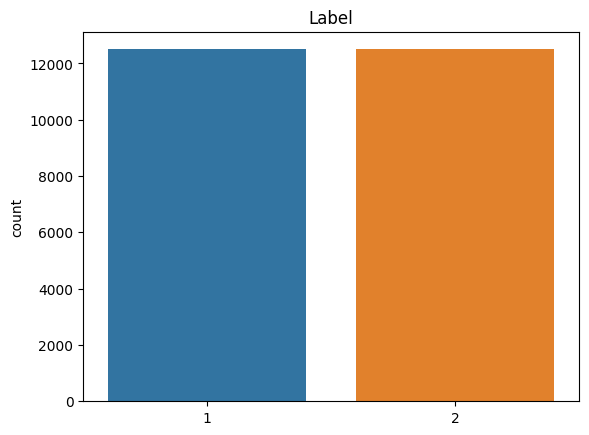

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
label = []
for i in range(len(train_data)):
    label.append(train_data[i][0])

sns.countplot(x=label)
plt.title ('Label')
plt.show()

In [ ]:
def make_vocab(data, min_freq):
    vocab = {}
    for label, tokenlist in data:
        for token in tokenlist:
            if token not in vocab:
                vocab[token] = 0
            vocab[token] += 1
    vocablist = [('<unk>', 0), ('<pad>', 0), ('<cls>', 0), ('<eos>', 0)]
    vocabidx = {}
    for token, freq in vocab.items():
        if freq >= min_freq:
            idx = len(vocablist)
            vocablist.append((token, freq))
            vocabidx[token] = idx
    vocabidx['<unk>'] = 0
    vocabidx['<pad>'] = 1
    vocabidx['<cls>'] = 2
    vocabidx['<eos>'] = 3
    return vocablist, vocabidx


vocablist, vocabidx = make_vocab(train_data, 10)

In [ ]:
def preprocess(data, vocabidx):
    processed_data = []
    for label, tokenlist in data:
        tkl = ['<cls>']
        for token in tokenlist:
            tkl.append(token if token in vocabidx else '<unk>')
        tkl.append('<eos>')
        processed_data.append((label, tkl))
    return processed_data

train_data = preprocess(train_data, vocabidx)
test_data = preprocess(test_data, vocabidx)

In [ ]:
def make_batch(data, batchsize):
    batches = []
    b_labels = []
    b_tokenlists = []
    for label, tokenlist in data:
        b_labels.append(label)
        b_tokenlists.append(tokenlist)
        if len(b_labels) >= batchsize:
            batches.append((b_tokenlists, b_labels))
            b_labels = []
            b_tokenlists = []
    if len(b_labels) > 0:
        batches.append((b_tokenlists, b_labels))
    return batches


train_data = make_batch(train_data, BATCHSIZE)
test_data = make_batch(test_data, BATCHSIZE)

In [ ]:
def padding(batches):
    for tokenlists, labels in batches:
        maxlen = max([len(x) for x in tokenlists])
        for tkl in tokenlists:
            for _ in range(maxlen - len(tkl)):
                tkl.append('<pad>')
    return batches


train_data = padding(train_data)
test_data = padding(test_data)

In [ ]:
def word2id(batches, vocabidx):
    converted_data = []
    for tokenlists, labels in batches:
        id_labels = [label - 1 for label in labels]
        id_tokenlists = []
        for tokenlist in tokenlists:
            id_tokenlists.append([vocabidx[token] for token in tokenlist])
        converted_data.append((id_tokenlists, id_labels))
    return converted_data


train_data = word2id(train_data, vocabidx)
test_data = word2id(test_data, vocabidx)

In [ ]:
n_layers = 2
input_dim = len(vocablist)
emb_dim = 128
output_dim = 2
hidden_dim = 256
class LSTM(torch.nn.Module):
  def __init__(self, input_dim, output_dim, emb_dim, hidden_dim, n_layers, dropout= 0.5):
    super(LSTM, self).__init__()
    self.n_layers = n_layers
    self.hidden_dim = hidden_dim
    self.emb = torch.nn.Embedding(input_dim, emb_dim, padding_idx = vocabidx['<pad>'])
    self.dropout = torch.nn.Dropout(0.5)
    self.lstm = torch.nn.LSTM(emb_dim, hidden_dim, n_layers, dropout =0.5)
    self.fc = torch.nn.Linear(self.hidden_dim, output_dim)

  def forward(self, x):
    e = self.dropout(self.emb(x))
    out, (hidden, cell) = self.lstm(e)
    for i in range(x.size()[0]):
      output = self.fc(out[-1])
    return output

In [ ]:
def train():
    model = LSTM(input_dim, output_dim, 300, 128, n_layers).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    for epoch in range(EPOCHS):
        loss = 0
        for tokenlists, labels in train_data:
            tokenlists = torch.tensor(tokenlists, dtype=torch.long).transpose(0, 1).to(DEVICE)
            labels = torch.tensor(labels, dtype=torch.long).to(DEVICE)
            optimizer.zero_grad()
            logits = model(tokenlists)
            batch_loss = F.cross_entropy(logits, labels)
            batch_loss.backward()
            optimizer.step()
            loss += batch_loss.item()

        print("Epoch", epoch + 1, "Loss:", loss / len(train_data))

    torch.save(model.state_dict(), MODELNAME)

In [ ]:
train()

Epoch 1 Loss: 0.5641748308182677
Epoch 2 Loss: 0.5025628686446668
Epoch 3 Loss: 0.4534835527505716
Epoch 4 Loss: 0.405535626756337
Epoch 5 Loss: 0.3523941966978943
Epoch 6 Loss: 0.3226012429008094
Epoch 7 Loss: 0.27654169126392325
Epoch 8 Loss: 0.25052328755521713
Epoch 9 Loss: 0.22308550418719
Epoch 10 Loss: 0.20651289229960088


In [ ]:
def test():
    model = LSTM(input_dim, output_dim, 300, 128, n_layers).to(DEVICE)
    model.load_state_dict(torch.load(MODELNAME))
    model.eval()

    total = 0
    correct = 0
    with torch.no_grad():
        for tokenlists, labels in test_data:
            tokenlists = torch.tensor(tokenlists, dtype=torch.long).transpose(0, 1).to(DEVICE)
            labels = torch.tensor(labels, dtype=torch.long).to(DEVICE)
            logits = model(tokenlists)
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total

    print("Correct: ",correct)
    print("Total: ",total)
    print("Accuracy:",accuracy)

In [ ]:
test()

Correct:  22153
Total:  25000
Accuracy: 0.88612
